In [11]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, f1_score, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [2]:
data_file_paths = [f'./data/raw/Churn_Modelling_{country}.csv'  for country in ['Spain', 'France']]

In [3]:
df = pd.concat([pd.read_csv(fpath) for fpath in data_file_paths])
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
1,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
2,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
3,15737173,Andrews,497,Spain,Male,24,3,0.00,2,1,0,76390.01,0
4,15600882,Scott,635,Spain,Female,35,7,0.00,2,1,1,65951.65,0


In [4]:
df.shape

(7491, 13)

In [5]:
# Are there missing values?
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df['Geography'].value_counts()

Geography
France    5014
Spain     2477
Name: count, dtype: int64

In [7]:
feat_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'

In [8]:
X, y = df[feat_cols], df[targ_col]

In [12]:
y.mean()

0.16326258176478442

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

clf = RandomForestClassifier(random_state=random_state, 
                            **train_params)
model = Pipeline(
    steps=[("preprocessor", SimpleImputer()), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [15]:
y_prob = model.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
f1, roc_auc

(0.5474137931034483, 0.8684327537866781)

<Axes: >

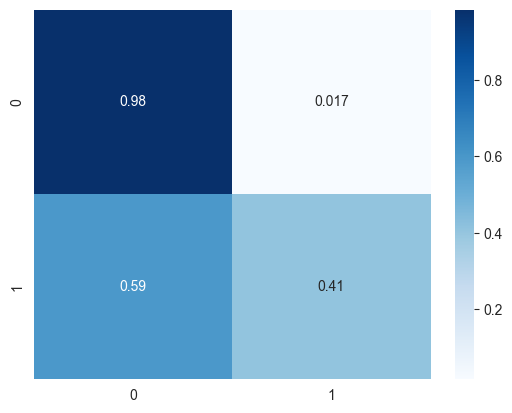

In [17]:
cm = confusion_matrix(y_test, y_pred, normalize='true') 
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)

In [19]:
out_feat_names = model[:-1].get_feature_names_out(feat_cols)
out_feat_names

array(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], dtype=object)

In [27]:
import subprocess
import sys

# Install eli5 package
subprocess.check_call([sys.executable, "-m", "pip", "install", "eli5"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "rfc"])

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Re-import eli5 and retry the previous operation
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

from rfc import permutation_importances

preprocessor = model.named_steps['preprocessor']
clf = model.named_steps['clf']
X_test_transformed = preprocessor.transform(X_test)

# Zamień PermutationImportance z rfc
perm = PermutationImportance(clf, scoring=make_scorer(f1_score), random_state=random_state).fit(X_test_transformed,
                                                                                                y_test)
eli5.show_weights(perm, feature_names=out_feat_names)

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for rfc: filename=rfc-0.1.0-py3-none-any.whl size=2093 sha256=4d859423acdc3ba65df701587f640ae9986f47d3c8e569b4e03f9addea69b6e0
  Stored in directory: /Users/apple/Library/Caches/pip/wheels/25/a7/89/a940276ca59b44ac39bc00a6caa1383bc3e6db8d3c77daffa3
Successfully built rfc


ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/Users/apple/open-source-mlops-e2e/.venv/lib/python3.12/site-packages/sklearn/utils/metaestimators.py)

In [23]:
feat_imp = zip(X_test.columns.tolist(), perm.feature_importances_)
df_feat_imp = pd.DataFrame(feat_imp, 
                    columns=['feature', 'importance'])
df_feat_imp = df_feat_imp.sort_values(by='importance', ascending=False)
df_feat_imp

NameError: name 'perm' is not defined

In [24]:
feat_importance_fpath = 'feat_imp.csv'
df_feat_imp.to_csv(feat_importance_fpath, index=False)

NameError: name 'df_feat_imp' is not defined

In [ ]:
from joblib import dump

dump(model, 'clf-model.joblib');